In [1]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        # x = torch.nn.Sigmoid()(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

model = UNetWithResnet50Encoder().cuda()
inp = torch.rand((1, 3, 512, 512)).cuda()
out = model(inp)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import HHS.model


warnings.filterwarnings('ignore')


class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        t = torch.Tensor([0.5]).cuda()  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input


class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(512)
        self.random_crop = torchvision.transforms.RandomCrop((512, 512))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta)
        if self.isTrain:
            target = self.random_crop(target)
        else:
            target = self.center_crop(target)
        return target


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

# load data
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def train(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/'+model_name
    os.mkdir(result_folder)
    model_path = os.path.join(result_folder, model_name)
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs}
    # save result dict
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        pbar = tqdm.tqdm(trainloader)
        model.train()
        for target in pbar:
            out = model(target)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            loss = tt.relativeLoss(result, target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for valid in validloader:
                out = model(valid)
                binary = sign_function(out)
                sim = tt.simulate(binary, z).abs()**2
                result = torch.mean(sim, dim=1, keepdim=True)
                psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(result, valid, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'max psnr: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')


def binary_sim(out, z=2e-3):
    binary = SignFunction.apply(out)
    sim = tt.simulate(binary, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return binary, res


def valid(model):
    with torch.no_grad():
        psnr_list = []
        for target in validloader:
            out = model(target)
            binary, res = binary_sim(out)
            psnr = tt.relativeLoss(res, target, tm.get_PSNR)
            psnr_list.append(psnr)
    print(sum(psnr_list)/len(psnr_list))


def check_order(bmodel, classifier, target):
    if len(target.shape) == 3:
        target = target.unsqueeze(0)
    result = []
    with torch.no_grad():
        out = bmodel(target)
        binary, res = binary_sim(out)
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


def check_order_without_model(binary, classifier):
    with torch.no_grad():
        result = []
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(64 * 64 * 64, 10)  # 최종 분류를 위한 FC 레이어

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 64 * 64)  # flatten
        x = self.fc(x)
        return x


def rgb_binary_sim(out, z):
    meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
    rmeta = {'wl': (638e-9), 'dx': (6.3e-6, 6.3e-6)}
    gmeta = {'wl': (515e-9), 'dx': (6.3e-6, 6.3e-6)}
    bmeta = {'wl': (450e-9), 'dx': (6.3e-6, 6.3e-6)}
    sign = SignFunction.apply
    binary = sign(out)
    channel = out.shape[1]
    rchannel = int(channel/3)
    gchannel = int(channel*2/3)
    red = binary[:, :rchannel, :, :]
    green = binary[:, rchannel:gchannel, :, :]
    blue = binary[:, gchannel:, :, :]
    red = tt.Tensor(red, meta=rmeta)
    green = tt.Tensor(green, meta=gmeta)
    blue = tt.Tensor(blue, meta=bmeta)
    rsim = tt.simulate(red, z).abs()**2
    gsim = tt.simulate(green, z).abs()**2
    bsim = tt.simulate(blue, z).abs()**2
    rmean = torch.mean(rsim, dim=1, keepdim=True)
    gmean = torch.mean(gsim, dim=1, keepdim=True)
    bmean = torch.mean(bsim, dim=1, keepdim=True)
    rgb = torch.cat([rmean, gmean, bmean], dim=1)
    rgb = tt.Tensor(rgb, meta=meta)
    binary = tt.Tensor(binary, meta=meta)
    return binary, rgb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
model = UNetWithResnet50Encoder(n_classes=3).cuda()
inp = torch.rand((1, 3, 512, 512)).cuda()
out = model(inp)
print(out.shape)

torch.Size([1, 3, 512, 512])


In [13]:
model = UNetWithResnet50Encoder(n_classes=24).cuda()
target = valid_dataset[0].unsqueeze(0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
psnr_list = []
crop = torchvision.transforms.CenterCrop(480)
crop_target = crop(target)
for epoch in tqdm.tqdm(range(5000)):
    out = model(target)
    # out = torch.nn.Sigmoid()(out)
    binary, rgb = rgb_binary_sim(out, 2e-3)
    crop_rgb = crop(rgb)
    psnr = tt.relativeLoss(crop_rgb, crop_target, tm.get_PSNR)
    loss = tt.relativeLoss(crop_rgb, crop_target, F.mse_loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    psnr_list.append(psnr)

100%|██████████| 5000/5000 [04:45<00:00, 17.50it/s]


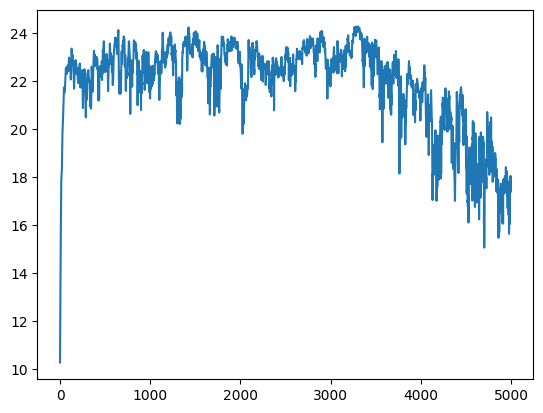

In [14]:
plt.plot(np.arange(len(psnr_list)), psnr_list)


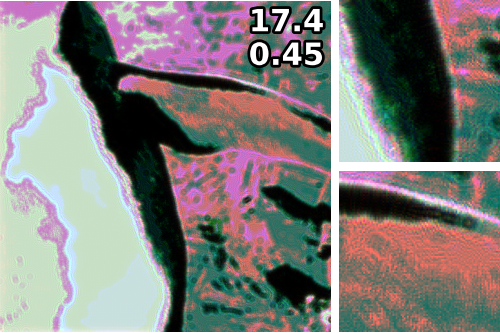

In [15]:
tt.show_with_insets(crop_rgb, crop_target, correct_colorwise=True)


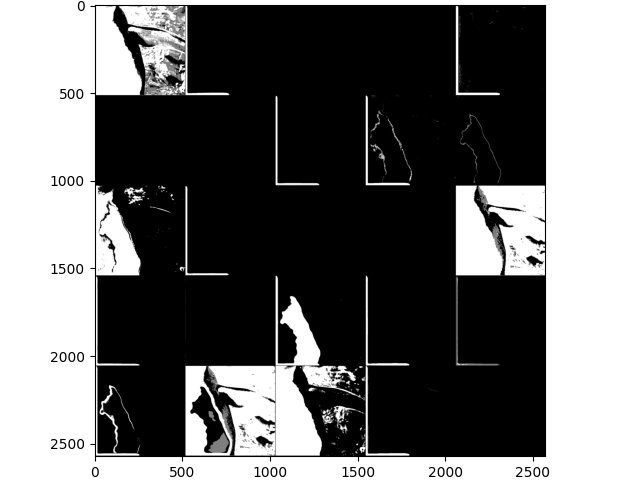

In [16]:
tt.show(binary)

In [25]:
model = HHS.model.FCN_Leakey_4(24, 'Sigmoid', 3, [16, 32, 64, 128]).cuda()
target = valid_dataset[0].unsqueeze(0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
psnr_list = []
crop = torchvision.transforms.CenterCrop(480)
crop_target = crop(target)
for epoch in tqdm.tqdm(range(5000)):
    out = model(target)
    binary, rgb = rgb_binary_sim(out, 2e-3)
    crop_rgb = crop(rgb)
    psnr = tt.relativeLoss(crop_rgb, crop_target, tm.get_PSNR)
    loss = tt.relativeLoss(crop_rgb, crop_target, F.mse_loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    psnr_list.append(psnr)

100%|██████████| 5000/5000 [01:09<00:00, 72.15it/s]


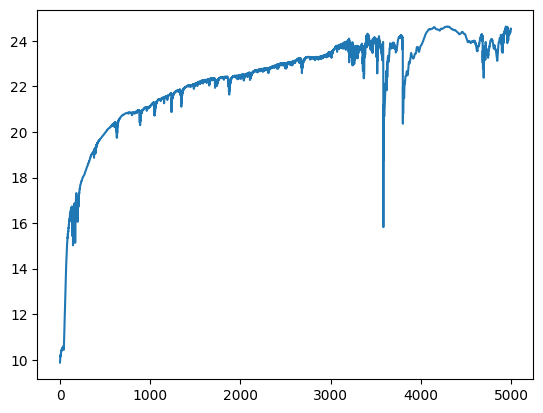

In [26]:
plt.plot(np.arange(len(psnr_list)), psnr_list)


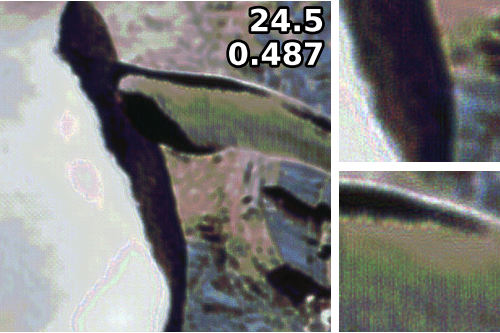

In [27]:
tt.show_with_insets(crop_rgb, crop_target, correct_colorwise=True)


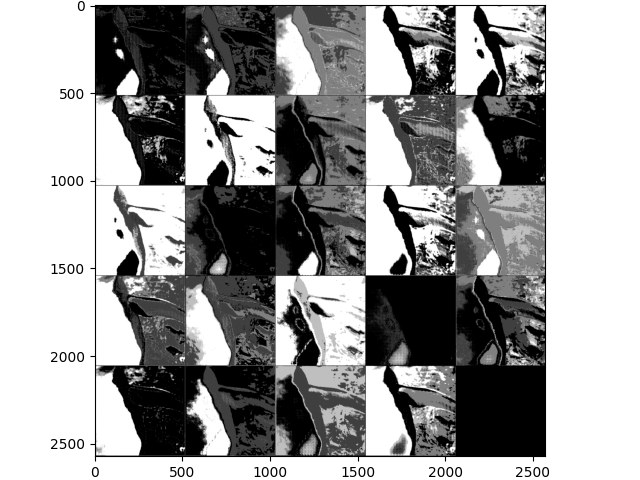

In [28]:
tt.show(binary)

In [3]:
def rgb_binary_train_padding(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3, dataset='DIV2K'):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    channels = []
    model.apply(initialize_weights)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    crop = torchvision.transforms.CenterCrop(480)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/layer6'+model_name
    os.mkdir(result_folder)
    num_parameters = count_parameters(model)
    model_path = os.path.join(result_folder, 'best')
    final_psth = os.path.join(result_folder, 'final')
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs,
            'num_parameters': num_parameters, 'channels': channels,
             'dataset': dataset}
    # save result dict
    train_psnr_list = []
    train_loss_list = []
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        pbar = tqdm.tqdm(trainloader)
        model.train()
        sum_train_psnr = 0
        sum_train_loss = 0
        for target in pbar:
            out = model(target)
            # out = torch.nn.Sigmoid()(out)
            binary, rgb = rgb_binary_sim(out, z)
            rgb = crop(rgb)
            croped_target = crop(target)
            loss = tt.relativeLoss(rgb, croped_target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            psnr = tt.relativeLoss(rgb, croped_target, tm.get_PSNR)
            sum_train_psnr = sum_train_psnr + psnr
            sum_train_loss = sum_train_loss + loss.detach().cpu().numpy()
        mean_train_psnr = sum_train_psnr/len(trainloader)
        mean_train_loss = sum_train_loss/len(trainloader)
        train_psnr_list.append(mean_train_psnr)
        train_loss_list.append(mean_train_loss)

        plt.plot(np.arange(len(train_psnr_list)), train_psnr_list, label=f'max psnr: {max(train_psnr_list)}')
        plt.title(model_name+'_train_psnr')
        plt.legend()
        plt.savefig(os.path.join(result_folder, 'trainPSNR.png'))
        plt.clf()
        
        plt.plot(np.arange(len(train_loss_list)), train_loss_list, label=f'min mse: {min(train_loss_list)}')
        plt.title(model_name+'_train_loss')
        plt.legend()
        plt.savefig(os.path.join(result_folder, 'trainMSE.png'))
        plt.clf()
        
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for idx, valid in enumerate(validloader):
                out = model(valid)
                # out = torch.nn.Sigmoid()(out)
                binary, rgb = rgb_binary_sim(out, z)
                rgb = crop(rgb)
                croped_target = crop(valid)
                psnr = tt.relativeLoss(rgb, croped_target, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(rgb, croped_target, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
                if idx == 0:
                    pl = tt.show_with_insets(rgb, croped_target, correct_colorwise=True)
                    pl.save(os.path.join(result_folder, 'penguin.png'))
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'min mse: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        torch.save(model.state_dict(), final_psth)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')

In [ ]:
model = UNetWithResnet50Encoder(n_classes=24).cuda()
rgb_binary_train_padding(model, num_hologram=24, custom_name='resnet', epochs=500, lr=1e-4, z=2e-3, dataset='DIV2K')

100%|██████████| 800/800 [01:59<00:00,  6.72it/s]


mean PSNR : 19.159491720199586 0/500
mean MSE : 0.012551229703240097 0/500
max_psnr: 19.159491720199586, epoch: 0


100%|██████████| 800/800 [01:59<00:00,  6.71it/s]


mean PSNR : 20.488903951644897 1/500
mean MSE : 0.009535475079901516 1/500
max_psnr: 20.488903951644897, epoch: 1


100%|██████████| 800/800 [01:59<00:00,  6.67it/s]


mean PSNR : 21.03349530220032 2/500
mean MSE : 0.008565838725771754 2/500
max_psnr: 21.03349530220032, epoch: 2


100%|██████████| 800/800 [02:00<00:00,  6.64it/s]


mean PSNR : 20.461024398803712 3/500
mean MSE : 0.00962337496690452 3/500
max_psnr: 21.03349530220032, epoch: 2


100%|██████████| 800/800 [01:59<00:00,  6.67it/s]


mean PSNR : 21.199251575469972 4/500
mean MSE : 0.00832348343450576 4/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.67it/s]


mean PSNR : 18.51491265296936 5/500
mean MSE : 0.014583350871689618 5/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.65it/s]


mean PSNR : 18.9113094997406 6/500
mean MSE : 0.013399812267161906 6/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.65it/s]


mean PSNR : 17.636450729370118 7/500
mean MSE : 0.018143637645989655 7/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.71it/s]


mean PSNR : 19.293386220932007 8/500
mean MSE : 0.012615937613882125 8/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.70it/s]


mean PSNR : 18.26759620666504 9/500
mean MSE : 0.015962796877138318 9/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.68it/s]


mean PSNR : 19.390966024398804 10/500
mean MSE : 0.012307006688788534 10/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.65it/s]


mean PSNR : 17.687909269332884 11/500
mean MSE : 0.018013989133760334 11/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.67it/s]


mean PSNR : 17.350738735198973 12/500
mean MSE : 0.018938348279334605 12/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.67it/s]


mean PSNR : 16.117912015914918 13/500
mean MSE : 0.026269308333285155 13/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.70it/s]


mean PSNR : 16.521232070922853 14/500
mean MSE : 0.023683230131864547 14/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.66it/s]


mean PSNR : 16.957218112945558 15/500
mean MSE : 0.021034063179977237 15/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.69it/s]


mean PSNR : 17.427168359756468 16/500
mean MSE : 0.01918966699857265 16/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.72it/s]


mean PSNR : 15.847164144515991 17/500
mean MSE : 0.02667922039050609 17/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.67it/s]


mean PSNR : 14.465400533676148 18/500
mean MSE : 0.03847144916653633 18/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.66it/s]


mean PSNR : 13.656172227859496 19/500
mean MSE : 0.04438610328361392 19/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.69it/s]


mean PSNR : 14.005292177200317 20/500
mean MSE : 0.043067800831049684 20/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.67it/s]


mean PSNR : 13.706907148361205 21/500
mean MSE : 0.04583864093758166 21/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.70it/s]


mean PSNR : 13.592678518295289 22/500
mean MSE : 0.04738867365755141 22/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.65it/s]


mean PSNR : 13.693734130859376 23/500
mean MSE : 0.046361696273088455 23/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.68it/s]


mean PSNR : 13.538789491653443 24/500
mean MSE : 0.04810520499944687 24/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [01:59<00:00,  6.70it/s]


mean PSNR : 13.416436100006104 25/500
mean MSE : 0.04910649681463838 25/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.66it/s]


mean PSNR : 13.410369815826416 26/500
mean MSE : 0.049490401884540916 26/500
max_psnr: 21.199251575469972, epoch: 4


100%|██████████| 800/800 [02:00<00:00,  6.64it/s]


mean PSNR : 14.249855270385742 27/500
mean MSE : 0.040709394421428444 27/500
max_psnr: 21.199251575469972, epoch: 4


  4%|▎         | 28/800 [00:04<02:01,  6.35it/s]